In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
df = pd.read_csv(r'/content/drive/MyDrive/POA FY25/features_anon.csv')
df.drop(columns=['Avg_Spend_Last_90'],inplace=True)

In [86]:
data  = df[['Recency','Frequency','AIT','Average Order Value','Cross_category_Count','Spending_Velocity','T']]

In [87]:
data.head(4)

,Recency,Frequency,AIT,Average Order Value,Cross_category_Count,Spending_Velocity,T
0,100,95,10.70,54812.39,10,0.53,1087.00
1,92,70,14.81,18910.58,10,1.18,1095.00
2,88,19,53.61,39324.50,7,0.34,1034.00
3,567,20,25.79,55912.05,8,0.00,1038.00


In [88]:
# Scale to minimize outliers effects

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

**KMEANS**

In [89]:
from sklearn.cluster import KMeans

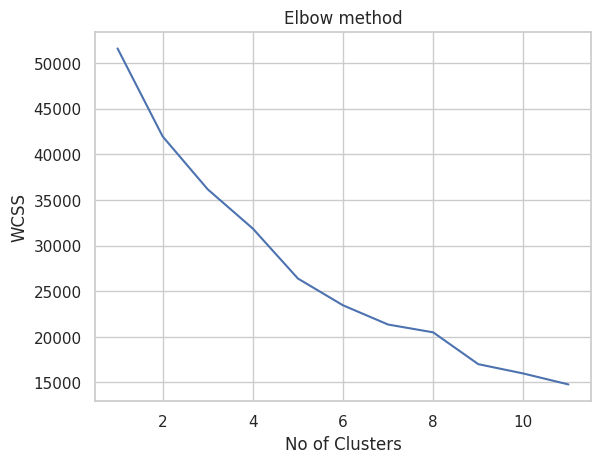

In [90]:
# Get the optimal K using either elbow method or Silhoutte score

list_of_inertia = []

for k in range(1,12):
  kmeans= KMeans(n_clusters=k,random_state=11)  # Fit data
  kmeans.fit(scaled_data)       # Calculate Inertia >> Within-Cluster Sum of Squares which is measure of compactness
  list_of_inertia.append(kmeans.inertia_)


# Plot
plt.plot(range(1,12),list_of_inertia)
plt.title('Elbow method')
plt.xlabel('No of Clusters')
plt.ylabel('WCSS')
plt.show()

**In the above we can see the line is smooth so we use silhoutte score**

The Silhouette Score is generally more reliable than the Elbow Method because

   - Cohesion: How close points are to their own cluster center.
   - Separation: How far points are from the nearest neighbor cluster

The optimal number of clusters is k=5


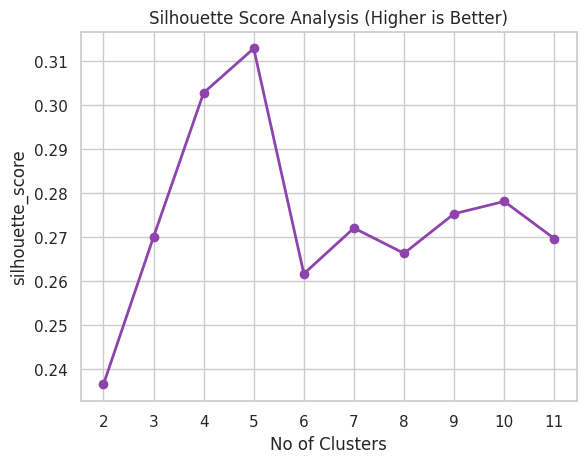

In [91]:
from sklearn.metrics import silhouette_score

silhoutte_score_list = []

for k in range(2,12):
  kmeans= KMeans(n_clusters=k,random_state=11)
  cluster_labels = kmeans.fit_predict(scaled_data)
  score = silhouette_score(scaled_data, cluster_labels)
  silhoutte_score_list.append(score)

# Plot
plt.plot(range(2,12),silhoutte_score_list,marker='o', color='#8E44AD', linewidth=2)
plt.title('Silhouette Score Analysis (Higher is Better)')
plt.xlabel('No of Clusters')
plt.ylabel('silhouette_score')
plt.xticks(range(2,12))
plt.grid(True)

best_k = range(2,12)[ silhoutte_score_list.index(max(silhoutte_score_list))]
print(f"The optimal number of clusters is k={best_k}")

In [92]:
# Train final model

pd.options.mode.chained_assignment = None

cluster_labels = KMeans(n_clusters=5,random_state=11).fit_predict(scaled_data)
data['kmeans_label'] = cluster_labels
data['kmeans_label'].value_counts().reset_index()

,kmeans_label,count
0,2,3318
1,1,1730
2,3,1391
3,0,916
4,4,17


**Density Models(DBSCAN,OPTICS)**

```
# This is Density Based Algorithm
```

1. Specializing in Arbitrary Shapes e.g U shaped ,Snake shaped
2. It handles Outliers better
3. Its finds naturally the number of clusters



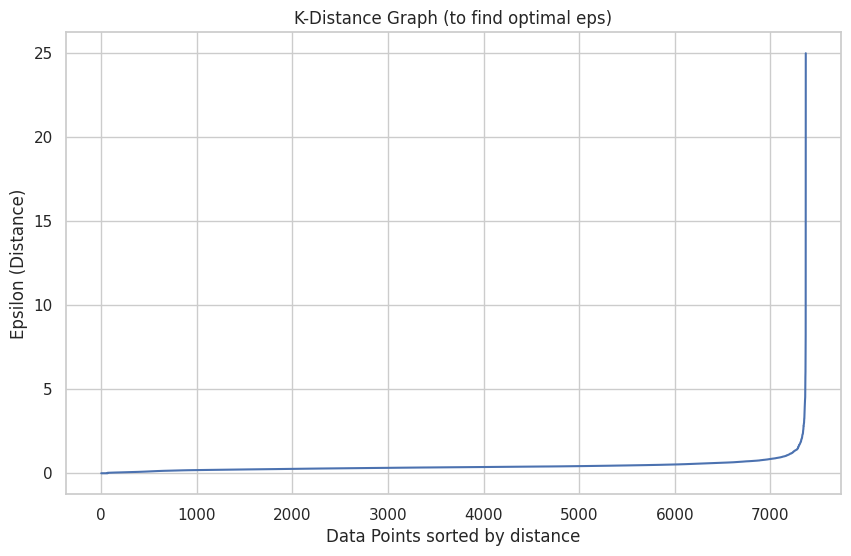

In [93]:
#  Find the optimal eps :v maximum distance between two points for them to be considered "neighbors

from sklearn.neighbors import NearestNeighbors

min_samples = 5

neighbors          = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit      = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# 2. Sort distances to plot the "Elbow"
distances = np.sort(distances[:, min_samples-1], axis=0)

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph (to find optimal eps)')
plt.ylabel('Epsilon (Distance)')
plt.xlabel('Data Points sorted by distance')
plt.grid(True)
plt.show()

In [94]:
from sklearn.cluster import DBSCAN

dbscan   = DBSCAN(eps=1.5, min_samples=5)
clusters               = dbscan.fit_predict(scaled_data)
data['dbscan_label'] = clusters

# Note: Label -1 means "Noise" (Outlier)
data['dbscan_label'].value_counts()

,count
dbscan_label,
0,7297
-1,58
1,12
2,5


In [95]:
# We test 3 values around the elbow to see which gives the best logical split
for eps_test in [0.5, 1.0,1.5, 2.0, 2.5]:

    db     = DBSCAN(eps=eps_test, min_samples=5).fit(scaled_data)
    labels = db.labels_

    # Calculate stats
    n_clusters    = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise       = list(labels).count(-1)
    noise_percent = (n_noise / len(labels)) * 100

    print(f"--- Testing eps={eps_test} ---")
    print(f"Clusters found: {n_clusters}")
    print(f"Noise points: {n_noise} ({noise_percent:.2f}%)")
    print("-" * 30)

--- Testing eps=0.5 ---
Clusters found: 15
Noise points: 1057 (14.34%)
------------------------------
--- Testing eps=1.0 ---
Clusters found: 5
Noise points: 155 (2.10%)
------------------------------
--- Testing eps=1.5 ---
Clusters found: 3
Noise points: 58 (0.79%)
------------------------------
--- Testing eps=2.0 ---
Clusters found: 3
Noise points: 34 (0.46%)
------------------------------
--- Testing eps=2.5 ---
Clusters found: 3
Noise points: 17 (0.23%)
------------------------------


**Connectivity Models** (Agglomerative Clustering)

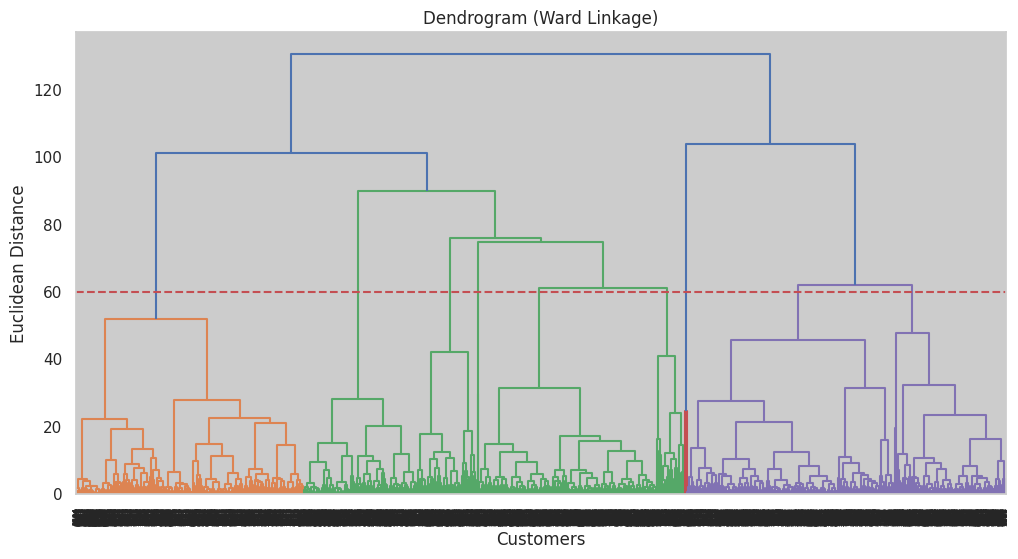

In [96]:
import scipy.cluster.hierarchy as sch

# 1. Calculate the Linkage Matrix (The history of merges)
# method='ward' is usually best for quantitative data
linkage_matrix = sch.linkage(scaled_data, method='ward')

# 2. Plot the Dendrogram
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)

plt.title('Dendrogram (Ward Linkage)')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.axhline(y=60, color='r', linestyle='--')
plt.show()

In [97]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')

data['hc_cluster'] = hc.fit_predict(scaled_data)

data['hc_cluster'].value_counts()

,count
hc_cluster,
0,3022
1,2524
3,1809
2,17


**Distribution Models: View data as a mixture of underlying probability functions, assigning points based on the likelihood they belong to a specific distribution (e.g., Gaussian Mixture Models)**

In [98]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd

# 1. Initialize and Fit
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(scaled_data)

# 2. Get the Labels (Hard Assignment)
data['gmm_label'] = gmm.predict(scaled_data)

# 3. Get the Probabilities (Soft Assignment)
# This returns a matrix where columns are clusters, rows are customers
probs = gmm.predict_proba(scaled_data)

# Example: See how "uncertain" the model is about the first 5 customers
print("Cluster Probabilities for first 5 customers:")
print(probs[:5].round(3))

Cluster Probabilities for first 5 customers:
[[0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.999 0.    0.    0.001]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


In [99]:
import pandas as pd
import numpy as np


prob_df = pd.DataFrame(
    probs,
    columns=[f'prob_cluster_{i}' for i in range(probs.shape[1])],
    index=data.index
)

data = pd.concat([data, prob_df], axis=1)
data['cluster_confidence'] = probs.max(axis=1)


In [100]:
pd.options.display.float_format = '{:.2f}'.format

**Evaluation Metrics**

In [104]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score